In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
sess = tf.Session()

C:\Users\xineoh\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)
    
texts, target = text_helpers.load_movie_data(data_folder_name)

In [5]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001
embedding_size = 200 # Word embedding size
doc_embedding_size = 100 # Document embedding size
concatenated_size = embedding_size + doc_embedding_size
num_sampled = int(batch_size/2)
window_size = 3 # How many words to consider to the left.
# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100
# Declare stop words
stops = stopwords.words('english')
# We pick a few test words.
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [6]:
texts = text_helpers.normalize_text(texts, stops)
# Texts must contain at least as much as the prior window size
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())> window_size]
texts = [x for x in texts if len(x.split()) > window_size]
assert(len(target)==len(texts))

In [7]:
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)
# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]

In [8]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))
# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size,concatenated_size],stddev=1.0 /np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [9]:
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1])
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [16]:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])
doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

# concatenate embeddings
final_embed = tf.concat([embed, tf.squeeze(doc_embed)],1)

In [18]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, y_target,final_embed, num_sampled, vocabulary_size))
# Create optimizer
optimizer =tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

In [20]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1,keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings,transpose_b=True)

In [22]:
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings":doc_embeddings})
init = tf.global_variables_initializer()
sess.run(init)

In [23]:
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))



Starting Training
Loss at step 100 : 641.5850830078125
Loss at step 200 : 587.7191162109375
Loss at step 300 : 637.9725952148438
Loss at step 400 : 578.5738525390625
Loss at step 500 : 577.4385986328125
Loss at step 600 : 547.7720336914062
Loss at step 700 : 569.7070922851562
Loss at step 800 : 521.1641235351562
Loss at step 900 : 533.1157836914062
Loss at step 1000 : 515.51513671875
Loss at step 1100 : 525.0551147460938
Loss at step 1200 : 537.1220703125
Loss at step 1300 : 543.8577880859375
Loss at step 1400 : 516.0918579101562
Loss at step 1500 : 491.4335021972656
Loss at step 1600 : 461.3145751953125
Loss at step 1700 : 475.10040283203125
Loss at step 1800 : 460.3434143066406
Loss at step 1900 : 424.7317199707031
Loss at step 2000 : 406.4236755371094
Loss at step 2100 : 465.34039306640625
Loss at step 2200 : 433.38299560546875
Loss at step 2300 : 453.3416442871094
Loss at step 2400 : 414.451416015625
Loss at step 2500 : 405.65972900390625
Loss at step 2600 : 387.3210754394531
Loss 

Loss at step 17600 : 167.71896362304688
Loss at step 17700 : 138.76708984375
Loss at step 17800 : 119.54015350341797
Loss at step 17900 : 151.97071838378906
Loss at step 18000 : 150.16839599609375
Loss at step 18100 : 142.18247985839844
Loss at step 18200 : 148.32046508789062
Loss at step 18300 : 159.77688598632812
Loss at step 18400 : 134.50363159179688
Loss at step 18500 : 135.78488159179688
Loss at step 18600 : 141.30429077148438
Loss at step 18700 : 163.1700439453125
Loss at step 18800 : 141.3870086669922
Loss at step 18900 : 145.66656494140625
Loss at step 19000 : 141.23031616210938
Loss at step 19100 : 142.95753479003906
Loss at step 19200 : 126.46379089355469
Loss at step 19300 : 119.00302124023438
Loss at step 19400 : 141.70938110351562
Loss at step 19500 : 147.53314208984375
Loss at step 19600 : 106.81063842773438
Loss at step 19700 : 142.72120666503906
Loss at step 19800 : 143.31581115722656
Loss at step 19900 : 115.5387191772461
Loss at step 20000 : 109.31397247314453
Neares

Model saved in file: C:\Users\xineoh\Documents\tensor_flow\temp\doc2vec_movie_embeddings.ckpt
Loss at step 35100 : 55.71979522705078
Loss at step 35200 : 60.62385559082031
Loss at step 35300 : 64.13522338867188
Loss at step 35400 : 52.71415328979492
Loss at step 35500 : 54.301841735839844
Loss at step 35600 : 68.84571838378906
Loss at step 35700 : 66.56743621826172
Loss at step 35800 : 76.20767211914062
Loss at step 35900 : 63.63216018676758
Loss at step 36000 : 73.21501922607422
Loss at step 36100 : 58.95844650268555
Loss at step 36200 : 55.48158264160156
Loss at step 36300 : 57.652679443359375
Loss at step 36400 : 64.76282501220703
Loss at step 36500 : 56.646705627441406
Loss at step 36600 : 71.90458679199219
Loss at step 36700 : 71.42807006835938
Loss at step 36800 : 61.08803176879883
Loss at step 36900 : 61.39896011352539
Loss at step 37000 : 62.7075080871582
Loss at step 37100 : 71.56028747558594
Loss at step 37200 : 63.60396957397461
Loss at step 37300 : 63.51120376586914
Loss at

Loss at step 52500 : 41.0301628112793
Loss at step 52600 : 44.30949783325195
Loss at step 52700 : 30.73812484741211
Loss at step 52800 : 49.72612380981445
Loss at step 52900 : 41.946189880371094
Loss at step 53000 : 49.70014572143555
Loss at step 53100 : 35.4803352355957
Loss at step 53200 : 41.62628173828125
Loss at step 53300 : 51.332420349121094
Loss at step 53400 : 51.34482192993164
Loss at step 53500 : 40.935890197753906
Loss at step 53600 : 45.35729217529297
Loss at step 53700 : 36.50004959106445
Loss at step 53800 : 34.960758209228516
Loss at step 53900 : 38.99509811401367
Loss at step 54000 : 35.475650787353516
Loss at step 54100 : 36.48881149291992
Loss at step 54200 : 30.658817291259766
Loss at step 54300 : 39.4403190612793
Loss at step 54400 : 34.74275207519531
Loss at step 54500 : 35.22764205932617
Loss at step 54600 : 40.01529312133789
Loss at step 54700 : 42.01713562011719
Loss at step 54800 : 44.65884780883789
Loss at step 54900 : 37.31645965576172
Loss at step 55000 : 4

Loss at step 70000 : 36.269954681396484
Nearest to love: comedy, one, funny, movie, like,
Nearest to hate: weighty, collateral, gets, overcome, characterdriven,
Nearest to happy: brown, script, emphasizes, awareness, grown,
Nearest to sad: best, watch, though, j, treatise,
Nearest to man: story, like, people, kind, little,
Nearest to woman: smart, pop, neither, watching, como,
Model saved in file: C:\Users\xineoh\Documents\tensor_flow\temp\doc2vec_movie_embeddings.ckpt
Loss at step 70100 : 27.414548873901367
Loss at step 70200 : 25.78131103515625
Loss at step 70300 : 20.803876876831055
Loss at step 70400 : 31.132448196411133
Loss at step 70500 : 30.945608139038086
Loss at step 70600 : 30.70450782775879
Loss at step 70700 : 23.900121688842773
Loss at step 70800 : 28.226049423217773
Loss at step 70900 : 30.3900089263916
Loss at step 71000 : 27.813457489013672
Loss at step 71100 : 33.24032211303711
Loss at step 71200 : 25.523258209228516
Loss at step 71300 : 28.917373657226562
Loss at ste

Loss at step 86400 : 19.293800354003906
Loss at step 86500 : 20.268465042114258
Loss at step 86600 : 19.62405014038086
Loss at step 86700 : 24.53110122680664
Loss at step 86800 : 21.884599685668945
Loss at step 86900 : 21.976333618164062
Loss at step 87000 : 24.28147315979004
Loss at step 87100 : 23.3753719329834
Loss at step 87200 : 20.047760009765625
Loss at step 87300 : 21.972227096557617
Loss at step 87400 : 22.779720306396484
Loss at step 87500 : 21.699420928955078
Loss at step 87600 : 23.430835723876953
Loss at step 87700 : 21.013835906982422
Loss at step 87800 : 18.394393920898438
Loss at step 87900 : 27.28325843811035
Loss at step 88000 : 23.02568244934082
Loss at step 88100 : 22.879549026489258
Loss at step 88200 : 21.67477798461914
Loss at step 88300 : 24.85953140258789
Loss at step 88400 : 24.422449111938477
Loss at step 88500 : 19.814191818237305
Loss at step 88600 : 20.04517364501953
Loss at step 88700 : 25.854656219482422
Loss at step 88800 : 21.003543853759766
Loss at st

In [25]:
# Start logistic model-------------------------
max_words = 20
logistic_batch_size = 500

# Split dataset into train and test sets
# Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# concatenate embeddings
log_final_embed = tf.concat( [log_embed, tf.squeeze(log_doc_embed)] ,1)

# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)

# Declare loss function (Cross Entropy loss)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

# Intitialize Variables
init = tf.initialize_all_variables()
sess.run(init)

In [26]:
# Start Logistic Regression
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # Append review index at the end of text data
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))




Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 8.09 (6.32). Train Acc (Test Acc): 0.45 (0.52)
Generation # 1000. Train Loss (Test Loss): 8.09 (7.76). Train Acc (Test Acc): 0.51 (0.54)
Generation # 1500. Train Loss (Test Loss): 7.13 (7.82). Train Acc (Test Acc): 0.52 (0.47)
Generation # 2000. Train Loss (Test Loss): 7.69 (8.57). Train Acc (Test Acc): 0.54 (0.53)
Generation # 2500. Train Loss (Test Loss): 8.12 (8.90). Train Acc (Test Acc): 0.54 (0.51)
Generation # 3000. Train Loss (Test Loss): 8.56 (10.20). Train Acc (Test Acc): 0.58 (0.50)
Generation # 3500. Train Loss (Test Loss): 6.92 (8.97). Train Acc (Test Acc): 0.58 (0.48)
Generation # 4000. Train Loss (Test Loss): 6.88 (7.97). Train Acc (Test Acc): 0.51 (0.49)
Generation # 4500. Train Loss (Test Loss): 5.71 (6.69). Train Acc (Test Acc): 0.55 (0.49)
Generation # 5000. Train Loss (Test Loss): 6.51 (7.11). Train Acc (Test Acc): 0.57 (0.55)
Generation # 5500. Train Loss (Test Loss): 7.15 (7.21). Tra

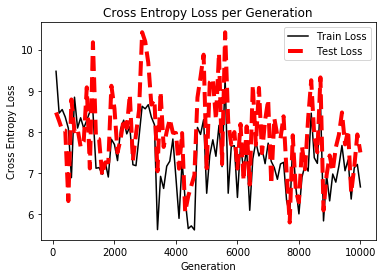

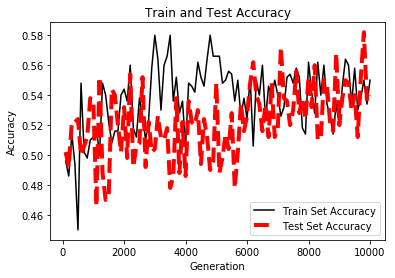

In [27]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()